# Geração da imagem virtual para cada par de foto tirada simultaneamente

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def matching_points(camera):
    MIN_MATCH_COUNT = 10
    img1 = cv2.imread(f'./images_to_virtual/image{camera}/image_1_{camera}.jpg', cv2.IMREAD_GRAYSCALE) # queryImage
    img2 = cv2.imread(f'./images_to_virtual/image{camera}/image_2_{camera}.jpg', cv2.IMREAD_GRAYSCALE) # trainImage
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()

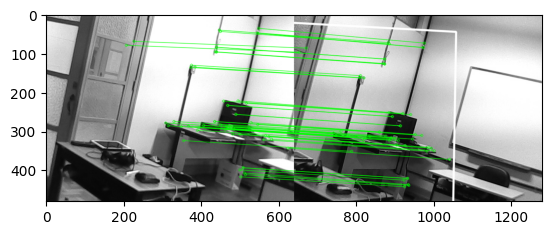

In [24]:
matching_points('1')

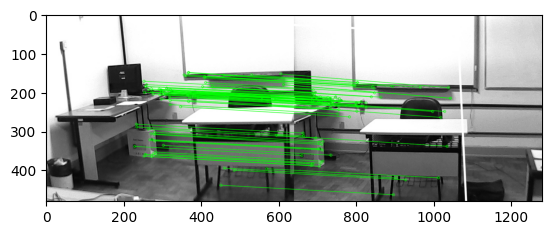

In [35]:
matching_points('2')

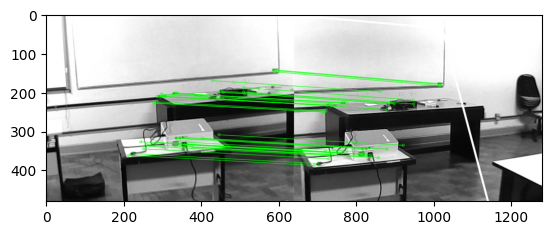

In [28]:
matching_points('3')